In [1]:
# Genetic_generation_net
!git clone https://github.com/Mike030668/Genetic_generation_net.git -q

!pip install stopit -q # установка библиотека контроля  времени
!pip install --upgrade mplfinance -q  # библиотека для отрисовки OHCL
!pip install yfinance -q  # requires yfinance - pip install yfinance

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.0/75.0 kB 661.6 kB/s eta 0:00:00


In [2]:
import sys
sys.path.append('/content/Genetic_generation_net')

from block_net.bricks import Set_net, Make_blocks
from block_net.constructor import WildregressModel
from block_net.estimate import estimator as est
from data.add_indicators import add_sma, add_ema, add_macd, add_vwap, add_obv, data_indicators, num_to_class, add_from_datetime
from data.preprocess import clean_dataset, future_sequence, df_for_mpf
from genetic.process_with_generator import selection

# imports

In [3]:
import numpy as np # библиотека нампи
import pandas as pd # библиотека пандас
import random as random  # Импортируем модель randim
import matplotlib.pyplot as plt # библиотека матплотлиб для отрисовки
from IPython.display import clear_output # очистка вывода в ячейке
import warnings # библиотека сообщений по ошибкам
warnings.filterwarnings("ignore") # игнорировать сообщения ошибок
import tensorflow as tf           # библиотека машинного обучения
from tqdm.notebook import tqdm   # отрисовка прохождения цикла
import gc                        # очиска памяти
import time                      # библиотека времени
# Нормировщики
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler

# Графики с библиотекой mplfinance
Расширение библиотеки  matplotlib для работы и построения графиков из датасетов

# **Данные с yfinance**

[документация](https://pypi.org/project/yfinance/)

In [4]:
import mplfinance as mpf  # библиотека для отрисовки OHCL
import yfinance as yf # requires yfinance - pip install yfinance
clear_output()

## 500 известных компаний с Wikipedia


Внимание - выбор случайного тикера может быть закомментирован

In [5]:
# публичный список 500 известных компаний с Wikipedia
df_wiki = pd.read_html("http://en.wikipedia.org/wiki/List_of_S%26P_500_companies")[0]

# случайный индекс
idx = np.random.choice(df_wiki.index)
# тикер и компания по случайному индексу
#tiker  = df_wiki.loc[idx].Symbol
tiker  = 'WY'
#company = df_wiki.loc[idx].Security
company = 'Weyerhaeuser'
print(f'Берем данные по случайному тикеру {tiker} комании - {company}')

Берем данные по случайному тикеру WY комании - Weyerhaeuser


In [6]:
# определяем параметры датасета
interval = "1d"
start = '2010-01-01'
stock = tiker
end = '2022-12-24'

# загружаем по тикеру и параметрам
df_tiker = yf.download(stock, start=start, end=end,  interval=interval, actions=False)
print(df_tiker.shape)
df_tiker.head()


[*********************100%%**********************]  1 of 1 completed

(3268, 6)


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2010-01-04,43.889999,44.430000,43.439999,44.279999,9.905472,1832400
2010-01-05,44.290001,45.240002,43.689999,45.220001,10.115748,1724500
2010-01-06,44.320000,45.230000,43.950001,44.720001,10.003897,2254400
2010-01-07,44.540001,44.639999,43.759998,44.520000,9.959159,1420700
2010-01-08,44.250000,44.450001,43.700001,44.110001,9.867440,1310000


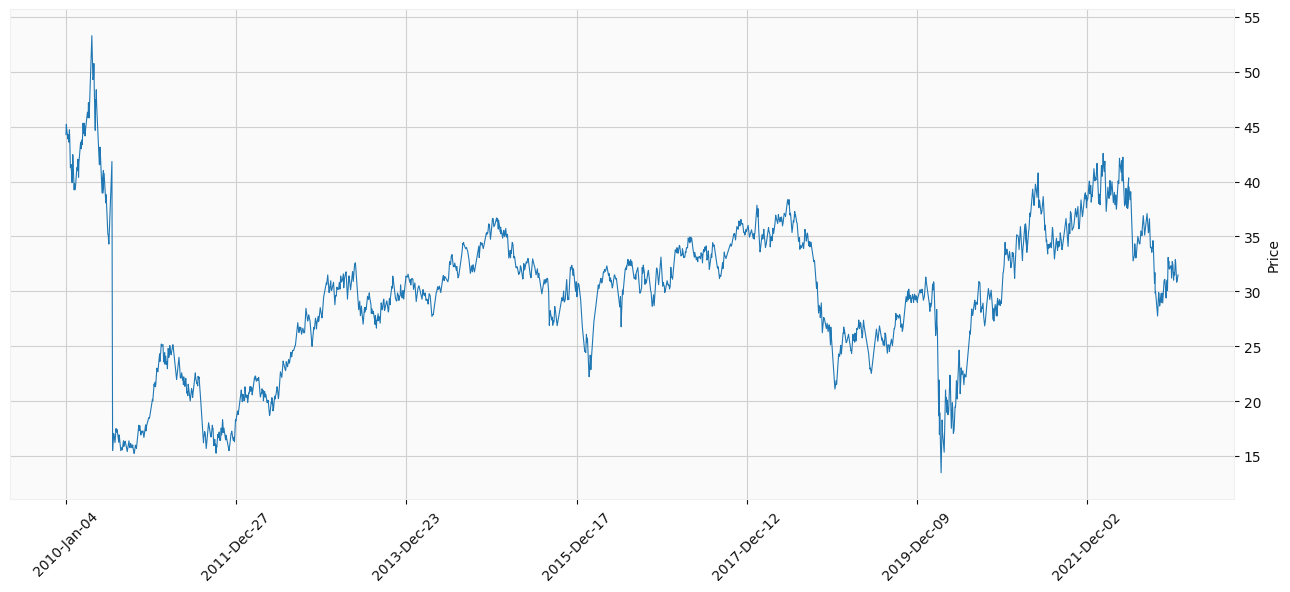

In [ ]:
# отрисовываем график с mplfinance
mpf.plot(df_tiker, style= 'yahoo', type='line', figsize = (17, 7));

# Подготовка данных

## Функции для подготовки данных


In [7]:
# обогощаем датасет на основе функци индикаторов
FEATURES =  ['High', 'Low', 'Close'] #, 'Adj Close''Open',

# то что выбросили , но требуется для отображения с MPF
ADD4MPF = list(set(['High', 'Low', 'Close', 'Open']).difference(set(FEATURES)))
print('То что выбросили, но требуется для отображения с MPF - ', ADD4MPF)
print()

DIFFBACK = 25
SET_WIND = [3, 5, 7]
df_data = data_indicators(df_tiker, DIFFBACK, SET_WIND, FEATURES)
df_data = add_from_datetime(df_data, add_classdays = False)

# переводим Volume в Log_Volume в df_data
df_data['Log_Volume'] = np.log(df_tiker['Volume'])
df_data

То что выбросили, но требуется для отображения с MPF -  ['Open']



,High,Low,Close,High_VWAP,Low_VWAP,Close_VWAP,High_OBV,Low_OBV,Close_OBV,High_diff_1,...,Low_EMA_5,Close_EMA_5,High_EMA_7,Low_EMA_7,Close_EMA_7,High_MACD,Low_MACD,Close_MACD,Mix_day,Log_Volume
Date,,,,,,,,,,,,,,,,,,,,,
2010-01-04,44.430000,43.439999,44.279999,44.430000,43.439999,44.279999,0.0,0.0,0.0,NaN,...,43.439999,44.279999,44.430000,43.439999,44.279999,0.000000,0.000000,0.000000,10.378479,14.421137
2010-01-05,45.240002,43.689999,45.220001,44.822715,43.561207,44.735742,1724500.0,1724500.0,1724500.0,0.018231,...,43.589999,44.844000,44.892858,43.582856,44.817143,0.064615,0.019943,0.074986,11.517913,14.360448
2010-01-06,45.230000,43.950001,44.720001,44.980715,43.712033,44.729636,-529900.0,3978900.0,-529900.0,-0.000221,...,43.760526,44.785264,45.038649,43.741621,44.775136,0.113706,0.056082,0.092995,12.288021,14.628394
2010-01-07,44.639999,43.759998,44.520000,44.913782,43.721456,44.688454,-1950600.0,2558200.0,-1950600.0,-0.013044,...,43.760307,44.675078,44.892857,43.748342,44.681829,0.103806,0.068599,0.090090,12.884005,14.166660
2010-01-08,44.450001,43.700001,44.110001,44.842657,43.718165,44.599742,-3260600.0,1248200.0,-3260600.0,-0.004256,...,43.737156,44.458152,44.747696,43.732496,44.494392,0.079710,0.072839,0.054082,13.374211,14.085538
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-19,31.610001,30.580000,30.830000,29.152080,28.446824,28.803384,307687800.0,608746900.0,640900000.0,0.000316,...,31.178074,31.523764,32.174191,31.287805,31.644406,0.101724,0.079359,0.055702,22.839482,14.928913
2022-12-20,31.100000,30.400000,30.910000,29.152452,28.447197,28.803786,304913700.0,605972800.0,643674100.0,-0.016134,...,30.918716,31.319176,31.905643,31.065853,31.460805,0.002058,-0.005240,-0.016609,23.586751,14.835837
2022-12-21,31.440001,30.750000,31.110001,29.152874,28.447621,28.804211,307588900.0,608648000.0,646349300.0,0.010932,...,30.862477,31.249451,31.789232,30.986890,31.373104,-0.048929,-0.043541,-0.057120,24.043827,14.799535


In [8]:
# параметр, который будем предсказывать
WIND_PRED = 3
USE2PRED = 'Close'
TYPE_PRED = 'SMA'
PRED_PRICE = f'{USE2PRED}_{TYPE_PRED}_{WIND_PRED}'
print(f'Предсказывать будем цену - {PRED_PRICE}')

# добавляем колонку TYPE_PRED WIND_PRED
df_data = add_sma(df_data, [WIND_PRED], [USE2PRED])
print(df_data.shape)

# Очистка датасетта от строк с nan, inf и -inf
df_data = clean_dataset(df_data)
print(df_data.shape)

Предсказывать будем цену - Close_SMA_3
(3268, 107)
(3243, 107)


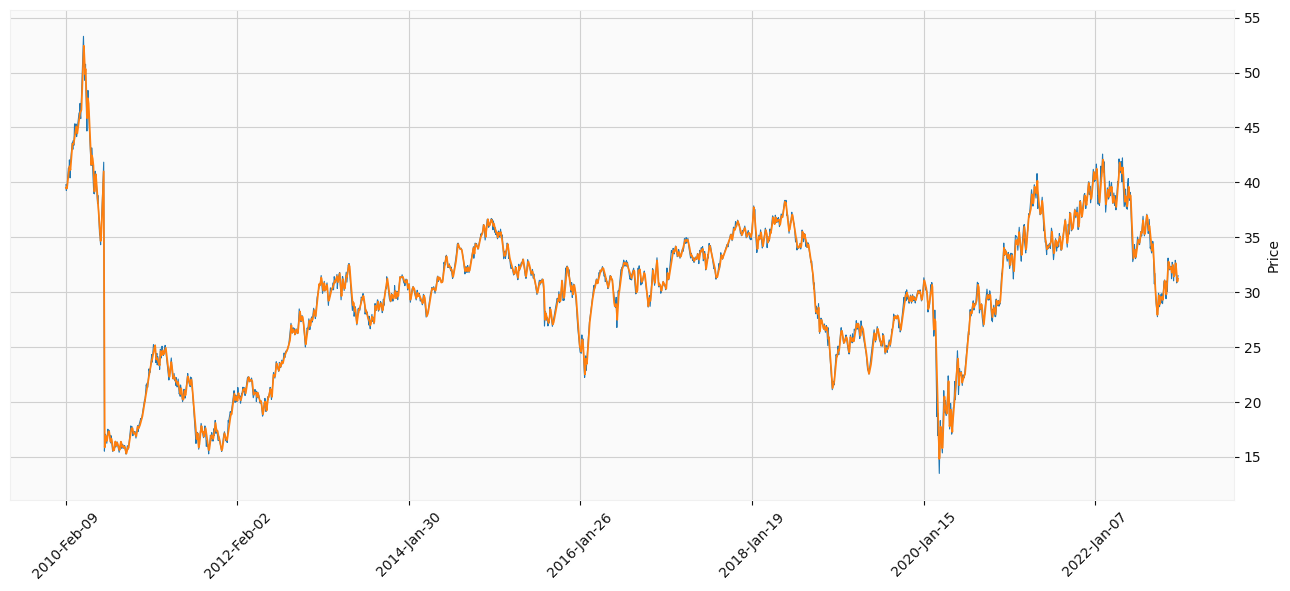

In [ ]:
# отрисовываем график Close с добавленным графиком по колонке df_data[PRED_PRICE]
df2show = df_for_mpf(df_data, df_tiker, ADD4MPF) # датафрейм, если убрали колонку требуемуе, то нужно добавить
mpf.plot(df2show,
         addplot= (mpf.make_addplot(df_data[PRED_PRICE])), # добавленый график df_data[PRED_PRICE]
         style= 'yahoo', type='line', figsize = (17, 7));

## Делим на Tain и Test


Учебный датасет


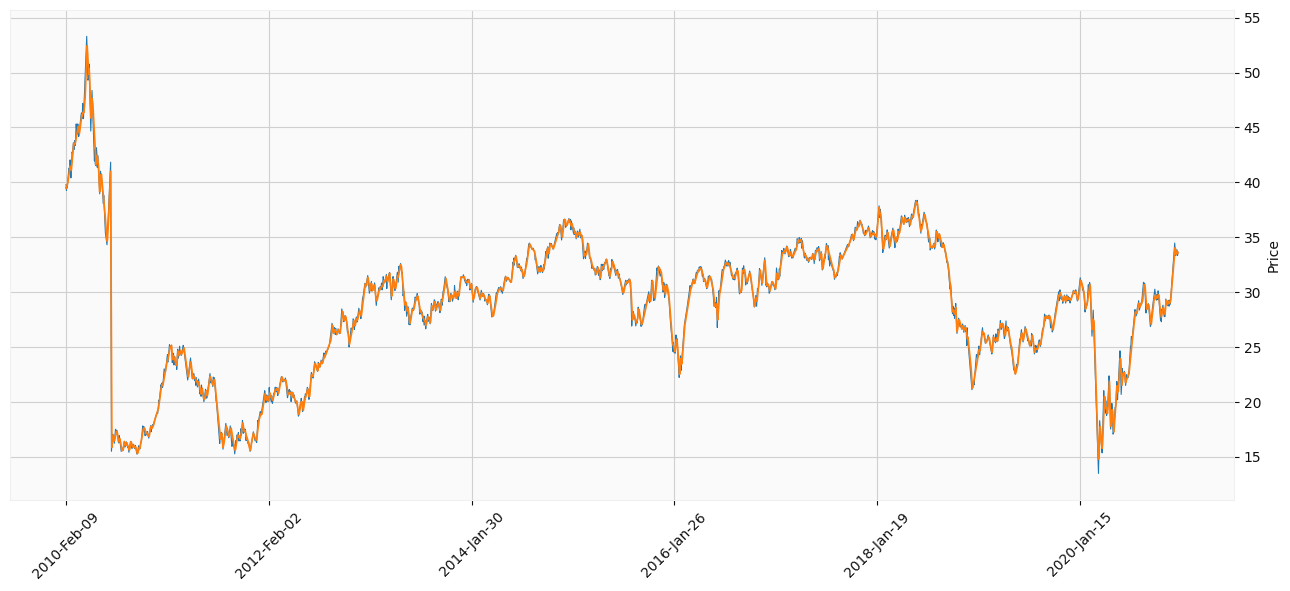

Тестовый датасет


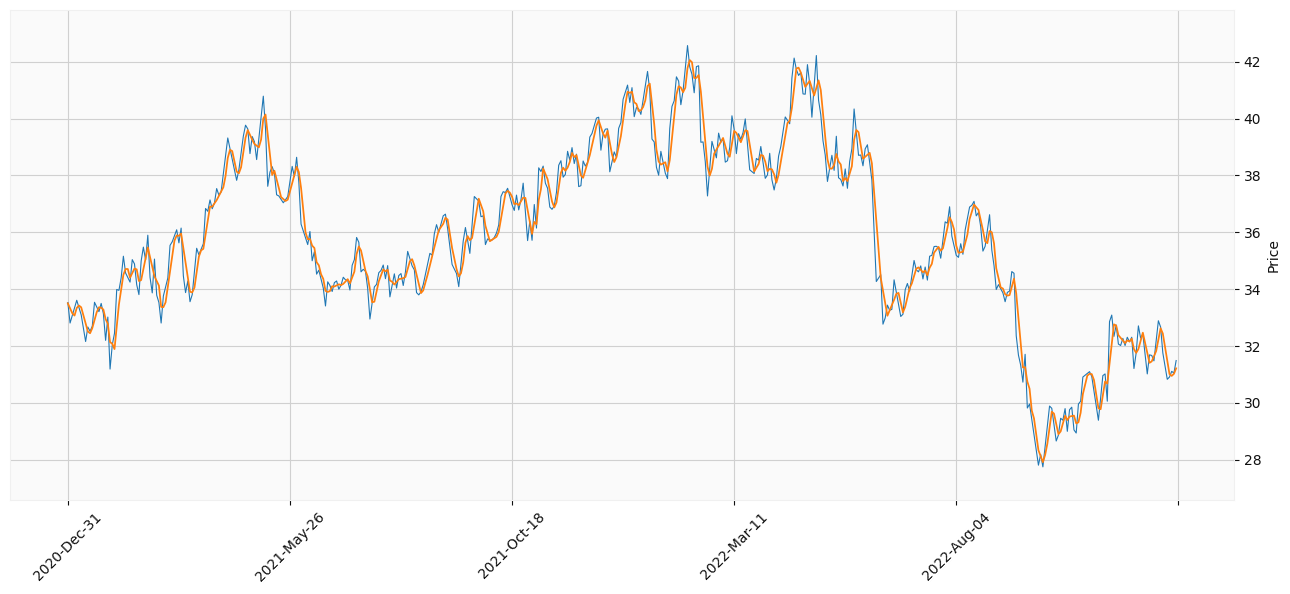

In [9]:
test_size = 500 # для теста откусим последние test_size значений
# Тренировочная выборка
print(f'Учебный датасет')
df_train = df_data[:-test_size]

df2show = df_for_mpf(df_train, df_tiker[:-test_size], ADD4MPF)
# отрисовываем график Close с добавленным графиком по колонке df_train[PRED_PRICE]
mpf.plot(df2show, # датафрейм
         addplot= (mpf.make_addplot(df_train[PRED_PRICE])), # добавленый график df_train[PRED_PRICE]
         style= 'yahoo', type='line', figsize = (17, 7));


# Тестовая выборка для симуляции торговли в реальном времени
print(f'Тестовый датасет')
df_test = df_data[-test_size:]

df2show = df_for_mpf(df_test, df_tiker[-test_size:], ADD4MPF)
# отрисовываем график Close с добавленным графиком по колонке df_test[PRED_PRICE]
mpf.plot(df2show,  # датафрейм
         addplot= (mpf.make_addplot(df_test[PRED_PRICE])), # добавленый график df_test[PRED_PRICE]
         style= 'yahoo', type='line', figsize = (17, 7));


## Подготовка данных для обучения

### Деление на Train датасет на TRAIN и VAL части

Предсказывать будем на 10_ть шагов

In [10]:
# Формируем параметры загрузки данных
DEPTH = DIFFBACK                         # Анализируем по DIFFBACK прошедшим точкам
VAL_LEN = 500                            # Используем 300 записей для проверки
PREDICT_LAG = 5                          # на сколько шагов вперед
TRAIN_LEN = df_train.shape[0] - VAL_LEN  # Размер тренировочной выборки
TRAIN_COLUMNS = df_train.columns[:-1]    # колонки для тренировочной выборки

# Делим данные на тренировочную и тестовую выборки
x_train, x_val = df_train[TRAIN_COLUMNS][:TRAIN_LEN - PREDICT_LAG + 1], \
                 df_train[TRAIN_COLUMNS][TRAIN_LEN + DEPTH + 2:-PREDICT_LAG + 1]

x_train.shape, x_val.shape

((2239, 106), (469, 106))

In [11]:
# Масштабируем данные (отдельно для X и Y), чтобы их легче было скормить сетке
X_SCAILER = MinMaxScaler(feature_range = (0, 1)) #  RobustScaler() # StandardScaler() #
X_SCAILER.fit(x_train)                  # обучаем X_SCAILER
x_train = X_SCAILER.transform(x_train)  # трансформируем x_train
x_val = X_SCAILER.transform(x_val)      # трансформируем x_val

x_train[0], x_val[0]

(array([0.64898064, 0.65141318, 0.64512744, 0.86883331, 0.87023397,
        0.86752266, 0.15882452, 0.01177474, 0.09079184, 0.78720888,
        0.89185498, 0.89973592, 0.78494515, 0.87038382, 0.84887984,
        0.72323144, 0.78937111, 0.80777132, 0.69060566, 0.72468696,
        0.75742046, 0.69831717, 0.73913747, 0.69988666, 0.75227193,
        0.76572118, 0.74845721, 0.74477415, 0.76130119, 0.76233814,
        0.72990973, 0.7371747 , 0.74577663, 0.72527621, 0.71275277,
        0.6938099 , 0.71520028, 0.69862027, 0.68558712, 0.71389174,
        0.68534502, 0.69323194, 0.69722691, 0.67155662, 0.70115415,
        0.63728956, 0.64792081, 0.66844533, 0.61046449, 0.58935371,
        0.60536485, 0.59392638, 0.57701602, 0.56402865, 0.6055032 ,
        0.57439749, 0.58259869, 0.59845352, 0.57293723, 0.57900102,
        0.57128149, 0.5656111 , 0.56485523, 0.57453459, 0.55573765,
        0.55800744, 0.56875715, 0.54069245, 0.54754415, 0.55927965,
        0.53841364, 0.54709302, 0.55353413, 0.53

In [12]:
# Для подготовки yTrain на PREDICT_LAG шагов вперед необходимо создать дополнительный датасет
# Для таргета берем колонку PRED_PRICE
y_train = future_sequence(df_train[PRED_PRICE][:TRAIN_LEN], PREDICT_LAG)
y_val =  future_sequence(df_train[PRED_PRICE][TRAIN_LEN + DEPTH + 2:], PREDICT_LAG)

# делаем ли np.log для у
MAKE_LOG = True
if MAKE_LOG:
  y_train = np.log(y_train)  # заменяем  y_train на log(y_train)
  y_val = np.log(y_val)      # заменяем  y_val на log(y_val)

print(y_train.shape, y_val.shape)
y_train[0], y_val[0]

(2239, 5) (469, 5)


(array([3.67621629, 3.67452696, 3.67764997, 3.67554089, 3.68587494]),
 array([3.23671575, 3.23933185, 3.24519316, 3.24778718, 3.25424298]))

In [13]:
# Масштабируем данные (отдельно для X и Y), чтобы их легче было скормить сетке
Y_SCAILER = MinMaxScaler(feature_range = (0, 1)) #  RobustScaler() # StandardScaler() #
Y_SCAILER.fit(y_train)                    # обучаем Y_SCAILER
y_train = Y_SCAILER.transform(y_train)    # трансформируем y_train
y_val = Y_SCAILER.transform(y_val)        # трансформируем y_val

y_train[0], y_val[0]

(array([0.77013313, 0.76876285, 0.77129603, 0.76958529, 0.77796758]),
 array([0.41363967, 0.41576167, 0.42051597, 0.42262007, 0.42785658]))

### Формируем генератор данных TimeseriesGenerator
- https://ru-keras.com/sequence-preprocessing/
- https://keras.io/api/preprocessing/timeseries/
- https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/sequence/TimeseriesGenerator

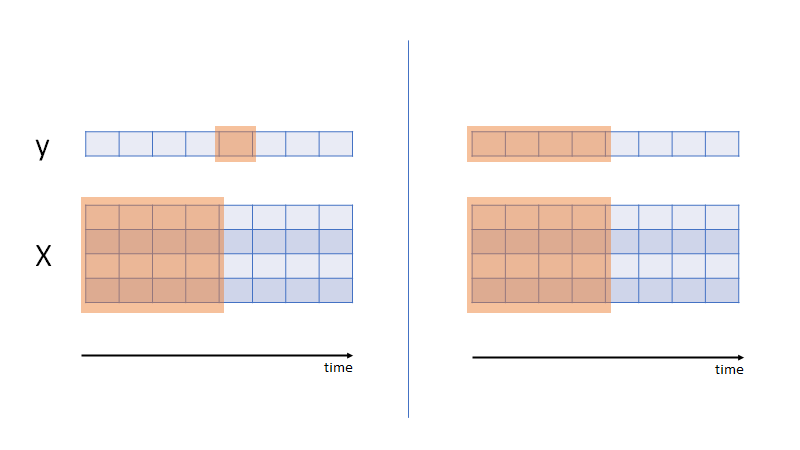

In [14]:
# Для генерации выборки временных рядов
TSG = tf.keras.preprocessing.sequence.TimeseriesGenerator

BATCH_SIZE = 32
# Создаем генератор для обучения
train_datagen = TSG(x_train, y_train,          # В качестве параметров наши выборки
                    length = DEPTH,            # Анализируем по 21 прошедшим точкам
                    sampling_rate = 1,         # Для каждой точки
                    batch_size = BATCH_SIZE)   # Размер batch, который будем скармливать модели

# Создаем аналогичный генератор для валидации при обучении
val_datagen = TSG(x_val, y_val,                # В качестве параметров наши выборки
                    length = DEPTH,            # Анализируем по 21 прошедшим точкам
                    sampling_rate = 1,         # Для каждой точки
                    batch_size = BATCH_SIZE)   # Размер batch, который будем скармливать модели

print(train_datagen[0][0].shape,
      val_datagen[0][1].shape)

# запомним входную размерность для модели обучения
INSHAPE = train_datagen[0][0].shape[1:]

(32, 25, 106) (32, 5)


In [15]:
# Создадим генератор проверочной выборки, из которой потом вытащим xVal, yVal для проверки/оценки
DataGen = TSG(x_val, y_val,              # В качестве параметров наши выборки
              length = DEPTH,            # Анализируем по 21 прошедшим точкам
              sampling_rate = 1,         # Для каждой точки
              batch_size = len(x_val))   # Размер batch будет равен длине нашей выборки


# сформируем сами массивы для проверки
XVAL, YVAL = [], []
for i in DataGen:
  XVAL.append(i[0])
  YVAL.append(i[1])

# так как это список объектов
# мы вытаскиваем нужный нам
XVAL = np.array(XVAL)[0]
YVAL = np.array(YVAL)[0]
print(XVAL.shape,YVAL.shape)

(444, 25, 106) (444, 5)


## Тест сборки сети

In [17]:
q_tyblocks = 7  # возможное количество блоков
q_lays = 10       # возможное количество слоев

# словарь типов сетей
style_net = {0: 'Dense',
             1: 'Conv',
             #2: 'Recur',
             None: 'MIX'
}
activ_lays =['relu', 'elu', 'tanh', 'sigmoid', 'selu', 'softmax',
             'softplus', 'softsign', 'hard_sigmoid', 'exponential']
activ_out = ['linear','relu', 'elu']

neiro_out = y_train.shape[1]      # нужное количество входных нейроной


type_net = random.choice(list(style_net.keys()))
print(f'Бот парамметров слоев сети - {style_net[type_net]}')

# инициализируем Set_net на основе заданных парамметров
choosing_net = Set_net(type_net, activ_lays, activ_out, neiro_out)
# инициализируем класс структуры блоков на основе парраметров сети
maker_blocks = Make_blocks(choosing_net)

# генерируем бот_популяции сетей
bot_pop = maker_blocks.buildpopulbot(q_tyblocks, q_lays)
print(f'Бот структуры популяции сетей - {bot_pop}')
# генерируем из состав блоков из к-ва блоков и слоев
structure = [np.random.randint(0,bot_pop[1]) for i in range(bot_pop[0])]
print(f'Макс. кол-во слоев в каждом блоке - {structure}')
# создаем единый список блоков для популяции
blockov_list = maker_blocks.sostav_blockov(structure)
print(f'Список списков имен слоев сети - {blockov_list}')
bot = maker_blocks.buildblock_bot(blockov_list)
print(f'Бот парамметров слоев сети - {bot}')

Бот парамметров слоев сети - MIX
Бот структуры популяции сетей - [6, 7, None, 1, 4, 5, 0, 2, 0, 0]
Макс. кол-во слоев в каждом блоке - [4, 6, 3, 4, 5, 6]
Список списков имен слоев сети - [['EmbRecur', 'Dense', 'activ', 'Embed', 'Recur', 'activ', 'EmbRecur'], ['SCnv1D', 'BatchN', 'activ', 'Dense', 'activ', 'Dense', 'activ', 'Conv1D', 'activ', 'Embed', 'Recur'], ['EmbRecur'], ['Conv1D', 'Dense', 'activ'], ['Recur', 'Conv1DT', 'activ', 'Dropout', 'Conv1D_dilation_block', 'activ', 'Dense'], ['SCnv1D', 'EmbRecur', 'activ', 'Conv1D_dilation_block', 'activ', 'Dense', 'activ']]
Бот парамметров слоев сети - [[4, 'gru', 64, 1, 102, 34, 'lstm', 8, 'True', 6, 11, 'gru'], [32, 2, 'same', 6, 8, 6, 32, 5, 4, 2, 'same', 7, 35, 20, 'gru', 14, 'False'], [16, 'lstm'], [4, 4, 'same', 4, 6], ['lstm', 5, 'True', 128, 5, 'same', 8, 0.15, 4, 4, 4, 4], [128, 3, 'valid', 6, 'gru', 0, 128, 4, 5, 4, 4]]


In [18]:

# инициализируем класс формирования сети
make_model = WildregressModel(INSHAPE)
# формируем модель из ботов
some_model = make_model(bot_pop,        # бот_популяции сетей
                        bot,            # бот парамметров слоев сети
                        blockov_list,   # список списков имен слоев сети
                        maker_blocks    # класс построения блоков
                        )

print()
print(bot_pop)


[6, 7, None, 1, 4, 5, 0, 2, 3, [0, 5, 1, 2, 3]]


In [19]:
# Отображение сводки модели
some_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 25, 106)]            0         []                            
                                                                                                  
 flatten (Flatten)           (None, 2650)                 0         ['input_1[0][0]']             
                                                                                                  
 embedding (Embedding)       (None, 2650, 64)             169600    ['flatten[0][0]']             
                                                                                                  
 gru (GRU)                   (None, 2650, 4)              840       ['embedding[0][0]']           
                                                                                              

In [20]:
trainable_count = np.sum([tf.keras.backend.count_params(w) for w in some_model.trainable_weights])
non_trainable_count = np.sum([tf.keras.backend.count_params(w) for w in some_model.non_trainable_weights])
trainable_count

374935

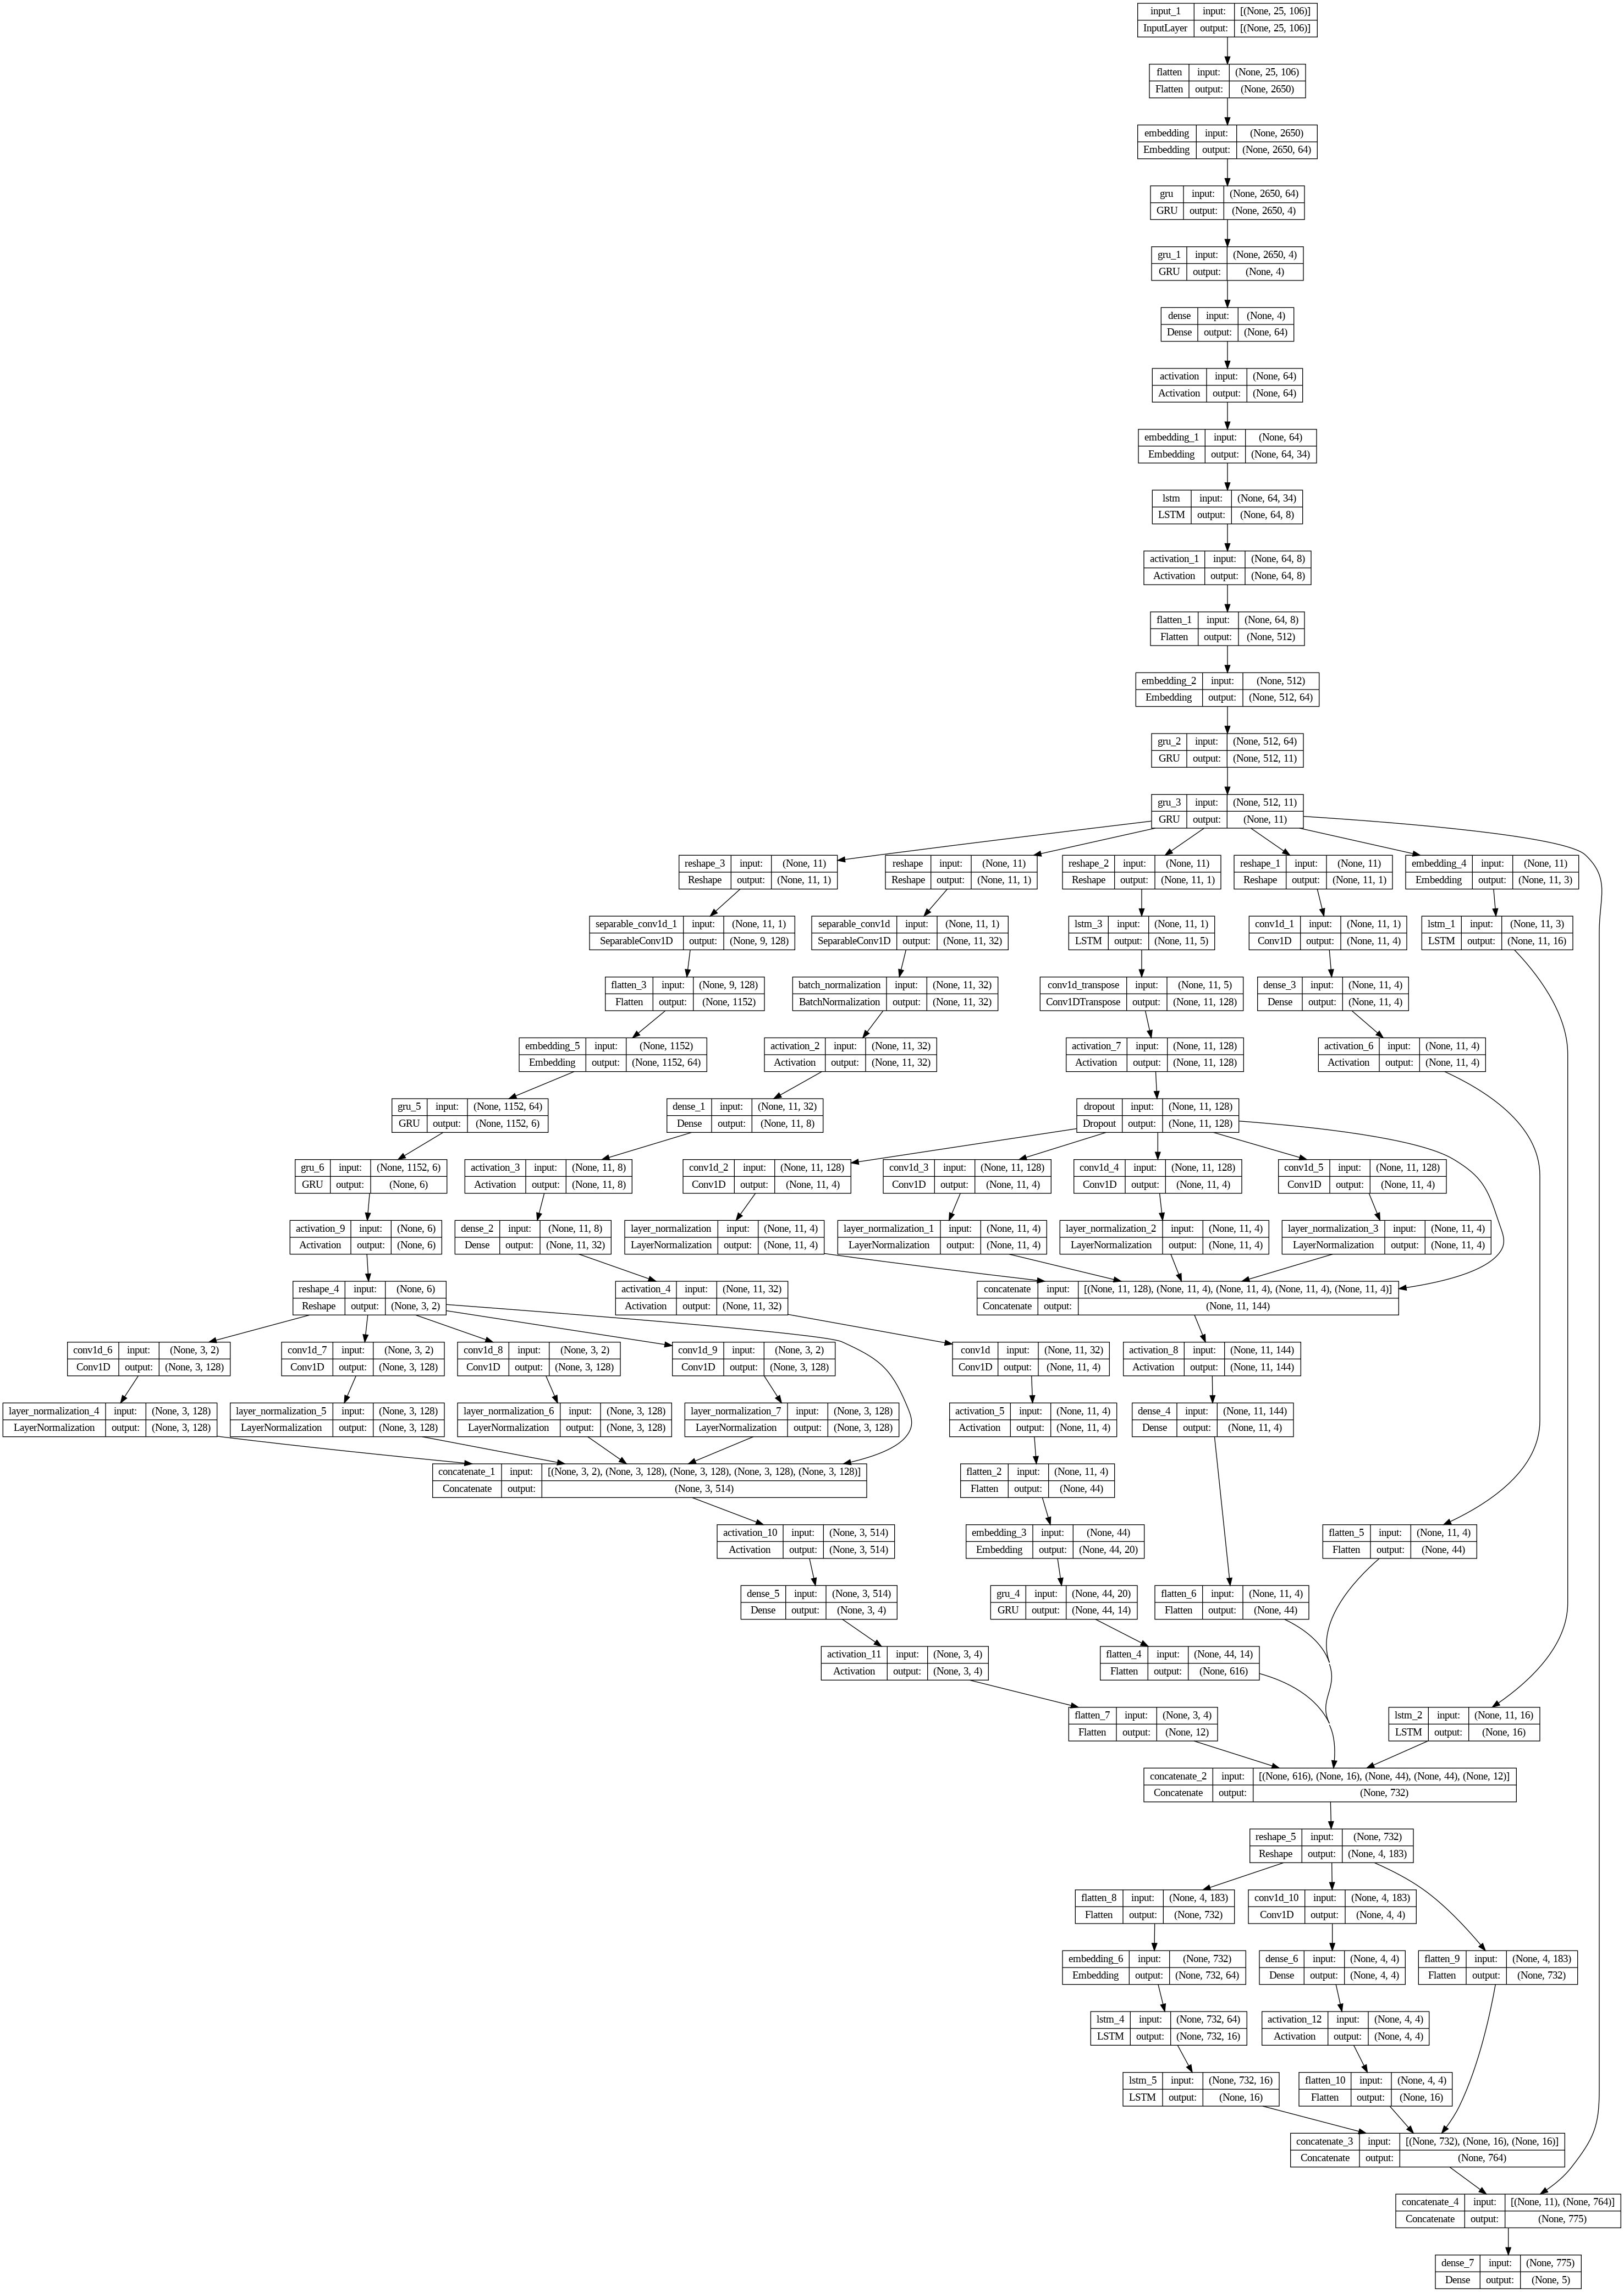

In [21]:
tf.keras.utils.plot_model(some_model, show_shapes=True)

In [23]:
# оптимизатор
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
# функция потерь
loss = tf.keras.losses.MSE

# получаем оценку по времени и смешанной точности нашей модели
result = est.evaluate_model(
                                  # парамметр от декаратора
                                  timeout = 25,                # время в сек отводимое на оценку
                                  # собственные парамметры функции
                                  model = some_model,          # тестируемая модель
                                  x_val = XVAL,
                                  y_val = YVAL,
                                  make_log = MAKE_LOG,
                                  y_scaler = Y_SCAILER,        # обученный скейлер для y
                                  type_data = "generator",
                                  train_data = train_datagen,   # генератор данных для обучения
                                  val_data = val_datagen,       # генератор данных для проверки
                                  ep = 3,                      # эпох обучения
                                  verb = 1,                    # отображать ли обучение
                                  optimizer = optimizer,       # оптимизатор
                                  loss = loss,                 # функция потерь
                                  channels = np.arange(PREDICT_LAG),  # Отображение сводки модели
                                  predict_lag = PREDICT_LAG)   # На сколько шагов предсказание

# выводим результат оценки
if len(result) > 2:
  clear_output()
  print(result)
else:
  print(f'Оценка модели как по ошибке и автокорреляции {result[0]:0.7f}')
  print(f'Среднее время эпохи {result[1]:0.2f} секунд')

Epoch 1/3
70/70 [==============================] - 9s 25ms/step - loss: 0.1205 - val_loss: 0.1521 - lr: 0.0010
Epoch 2/3
70/70 [==============================] - 1s 11ms/step - loss: 0.0243 - val_loss: 0.1243 - lr: 0.0010
Epoch 3/3
70/70 [==============================] - ETA: 0s - loss: 0.0075
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0006000000284984708.
14/14 [==============================] - 0s 3ms/step
Оценка модели как по ошибке и автокорреляции 0.2566060
Среднее время эпохи 3.32 секунд


# Генетический отбор нейронок

In [16]:
# ВЕРСИЯ КОДА С ПОСЕВОМ и генетикой в создании новых популяций

# оптимизатор
#optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
# функция потерь
#loss = tf.keras.losses.MSE

# Сохраняем массивы лучших моделей на диск
# [[[bot_pop_1],[blockov_list_1],[bot_1]],[[bot_pop_1],[blockov_list_1],[bot_1]]]
directory = '/content/' # gen_models/'  # куда  пишет данные этот код

########### посев сетей вначале кода ############################################
# posev = []
# смотри пояснения выше как передать сюда ранее созданные данные
# posev = np.load(directory +'bestnets.npy', allow_pickle = True)
# если еще нет список моделий, то ввести 0
# или можно вручную списки подать, указав вместо 0, сколько будкт сетей
# последовательно в ответ ввести  листы [bot_pop], [blockov_list], [bot]

# в текстовой ячейке ниже есть 2 сети для посева вручную

########### для подсевания лучших сетей прошлых эпох ###########################
waitnets = 3 # сколько выводим лучших для для изучения и посева
dw = 0.4 # доля лучших с прошлых эпох для подсева
frbest = 2 # как часто подсевыем лучших с прошлых эпох
################################################################################

########### папаметпы для генерируемых сетей ###################################
activ_lays =['relu', 'elu', 'tanh', 'sigmoid', 'selu', 'softmax',
             'softplus', 'softsign', 'hard_sigmoid', 'exponential']

# нужное количество входных нейроной
neiro_out = y_train.shape[1]

# функции активации для выходного слоя
activ_out = ['linear']
# словарь типов сетей
style_net = {0: 'Dense',
             1: 'Conv',
             #2: 'Recur', # На малом ОЗУ лучше закомитить
             #None: 'MIX'
}

################################################################################
q_tyblocks = 7   # макс количество генерируемых блоков для сети
q_lays = 7      # макс количество слоев в блоках
################################################################################
verbouse = 0     # отображать ли обучение
epohs = 3        # Количество эпох для генетического поиска моделей
test_eph = 2     # Количество эпох тестового обучения моделей
################################################################################

################################################################################
n = 7             # количество ботов популяции
p = 5             # количество популяций

dn = 0.3 # доля выживших ботов
dp = 0.3 # доля выживших популяций

dneff = 0.1 # доля выживших ботов по эффективности
dpeff = 0.1 # доля выживших популяций по эффективности

prb_randbot = 0.3 # вероятность появления случайного бота в новой популяции
mutp = 0.4   # Коэфициент мутаций при создании мегабота новой популяции
mutn = 0.45  # Коэфициент мутаций при создании бота новой сети в популяции

dpsurv = 0.8 # доля от выживших ботов популяции используемыех в родителях
dnsurv = 0.8 # доля от выживших ботов мегапопуляции используемыех в родителях

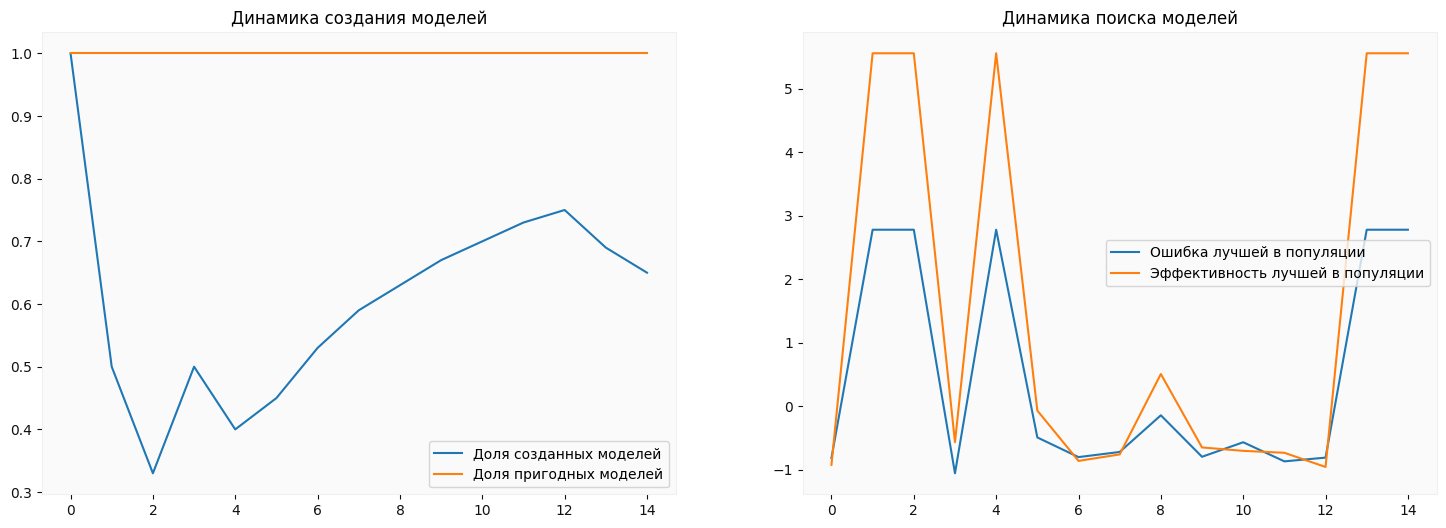


Мегапопуляция 4, эпоха 3
Модели популяции: создано [68, 0.65] брак [37, 0.35]
Модели популяции: пригодны [68, 1.0] не пригодны [37, 0.54]



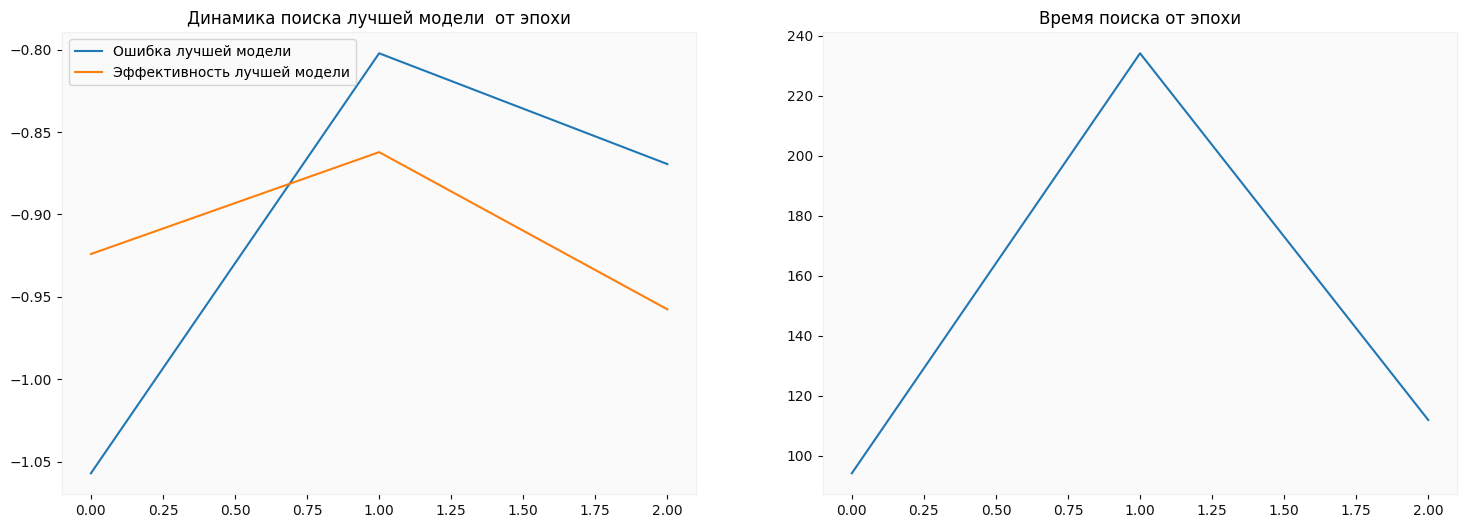


Эпоха 2, точность моделей [[1.35072473e-01 1.67803269e-01 2.54503610e-01 2.67422200e-01]
 [1.54713427e-01 1.58456509e-01 1.89073479e-01 2.92754164e-01]
 [2.70204588e-01 2.92484938e-01 2.94258701e-01 3.66702358e-01]
 [6.00000000e+02 6.00000000e+02 6.00000000e+02 6.00000000e+02]]
Время на эпоху 111.9157063961029, эффективность моделей [[1.10277378e-01 1.34953225e-01 1.49526864e-01 2.12046944e-01]
 [1.84345250e-01 2.59307034e-01 3.30771127e-01 3.91508074e-01]
 [1.97796779e-01 2.09196439e-01 2.32232424e-01 2.62482767e-01]
 [3.60000000e+05 3.60000000e+05 3.60000000e+05 3.60000000e+05]]
До окончания поиска 0 сек.
К-ко ошибок в длине ботов 0

Мегапопуляция 0 добавляем 5 ботов
Популяция 0, ботов 2
Популяция 0, дополнена до ботов 3
Популяция 0, дополнена до ботов 4
Популяция 0, дополнена до ботов 5
Популяция 0, дополнена до ботов 6
Популяция 0, дополнена до ботов 7
Популяция 0, ботов 7
Мегапопуляция 1 добавляем 5 ботов
Популяция 1, ботов 2
Популяция 1, дополнена до ботов 3
Популяция 1, дополне

In [17]:
selection(
        directory = directory,          # куда  пишет данные этот код
        waitnets = waitnets,
        dw = dw,                        #
        frbest = frbest,
        inshape = INSHAPE,
        x_val = XVAL,
        y_val = YVAL,
        make_log = MAKE_LOG,
        predit_lag = PREDICT_LAG,
        type_data = "generator",
        train_data = train_datagen,     # генератор данных для обучения
        val_data= val_datagen,
        y_scaler = Y_SCAILER,           # обученный скейлер для y
        activ_lays = activ_lays,
        neiro_out = neiro_out,
        activ_out = activ_out,
        style_net = style_net,
        q_tyblocks = q_tyblocks,
        q_lays = q_lays,
        verbouse = verbouse,
        epohs = epohs,
        test_eph = test_eph,
        #optimizer = optimizer,          # оптимизатор
        #loss = loss,                    # функция потерь
        n = n,                          # = 5 # количество ботов популяции
        p = p,                          #  = 6  # количество популяций
        dn = dn,                        #= 0.3 # доля выживших ботов
        dp = dp,                        # = 0.3 # доля выживших популяций
        dneff = dneff,                  # = 0.1 # доля выживших ботов по эффективности
        dpeff = dpeff,                  # = 0.1 # доля выживших популяций по эффективности
        prb_randbot = prb_randbot,      # = 0.3 # вероятность появления случайного бота в новой популяции
        mutp = mutp,                    # = 0.4   # Коэфициент мутаций при создании мегабота новой популяции
        mutn = mutn,                    # = 0.45  # Коэфициент мутаций при создании бота новой сети в популяции
        dpsurv = dpsurv,                # = 0.8 # доля от выживших ботов популяции используемыех в родителях
        dnsurv = dnsurv,                # = 0.8 # доля от выживших ботов мегапопуляции используемыех в родителях
        posev = [],
        check_aotocorr = True
)

# После генетики

## Генерация нейронки

In [18]:
from genetic.sowing import getnetfrombest
from block_net.constant import TIMELIMIT_1

In [22]:
#directory = '..папка куда сохранял ваш код выше../'  # куда пишет данные код
directory = '/content/' # 'Генетика/'  # куда пишет данные код
########### папаметпы для генерируемых сетей ###################################
activ_lays =['relu', 'elu', 'tanh', 'sigmoid', 'selu', 'softmax',
             'softplus', 'softsign', 'hard_sigmoid', 'exponential']
# нужное количество входных нейроной
neiro_out = y_train.shape[1]

# функции активации для выходного слоя
activ_out = ['linear']

# загружаем список парамметров лучших сетей
save_nets = np.load(directory+'bestnets.npy', allow_pickle = True)

# генерируем список моделей в количестве n
set_models = getnetfrombest(
                            INSHAPE,
                            save_nets.tolist(),
                            activ_lays,
                            activ_out, neiro_out,
                            limit = TIMELIMIT_1,
                            n = 3)


# После генетики

## Генерация нейронки

In [ ]:
#directory = '..папка куда сохранял ваш код выше../'  # куда пишет данные код
directory = 'Генетика/'  # куда пишет данные код
########### папаметпы для генерируемых сетей ###################################
activ_lays =['relu', 'elu', 'tanh', 'sigmoid', 'selu', 'softmax',
             'softplus', 'softsign', 'hard_sigmoid', 'exponential']
# нужное количество входных нейроной
neiro_out = y_train.shape[1]

# функции активации для выходного слоя
activ_out = ['linear', 'relu', 'elu']

# загружаем список парамметров лучших сетей
save_nets = np.load(directory+'bestnets.npy', allow_pickle = True)

# генерируем список моделей в количестве n
set_models = getnetfrombest(save_nets.tolist(), activ_lays,
                            activ_out, neiro_out,
                            limit = TIMELIMIT_1,
                            n = 3)


In [23]:
k = 0 # указываем индекс от 0 до n-1 для выбора модели
good_model = set_models[k]
good_model.call = tf.function(good_model.call)

# Отображение сводки модели
good_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_15 (InputLayer)       [(None, 25, 106)]            0         []                            
                                                                                                  
 conv1d (Conv1D)             (None, 25, 4)                1700      ['input_15[0][0]']            
                                                                                                  
 conv1d_1 (Conv1D)           (None, 21, 4)                84        ['conv1d[0][0]']              
                                                                                                  
 activation (Activation)     (None, 21, 4)                0         ['conv1d_1[0][0]']            
                                                                                              

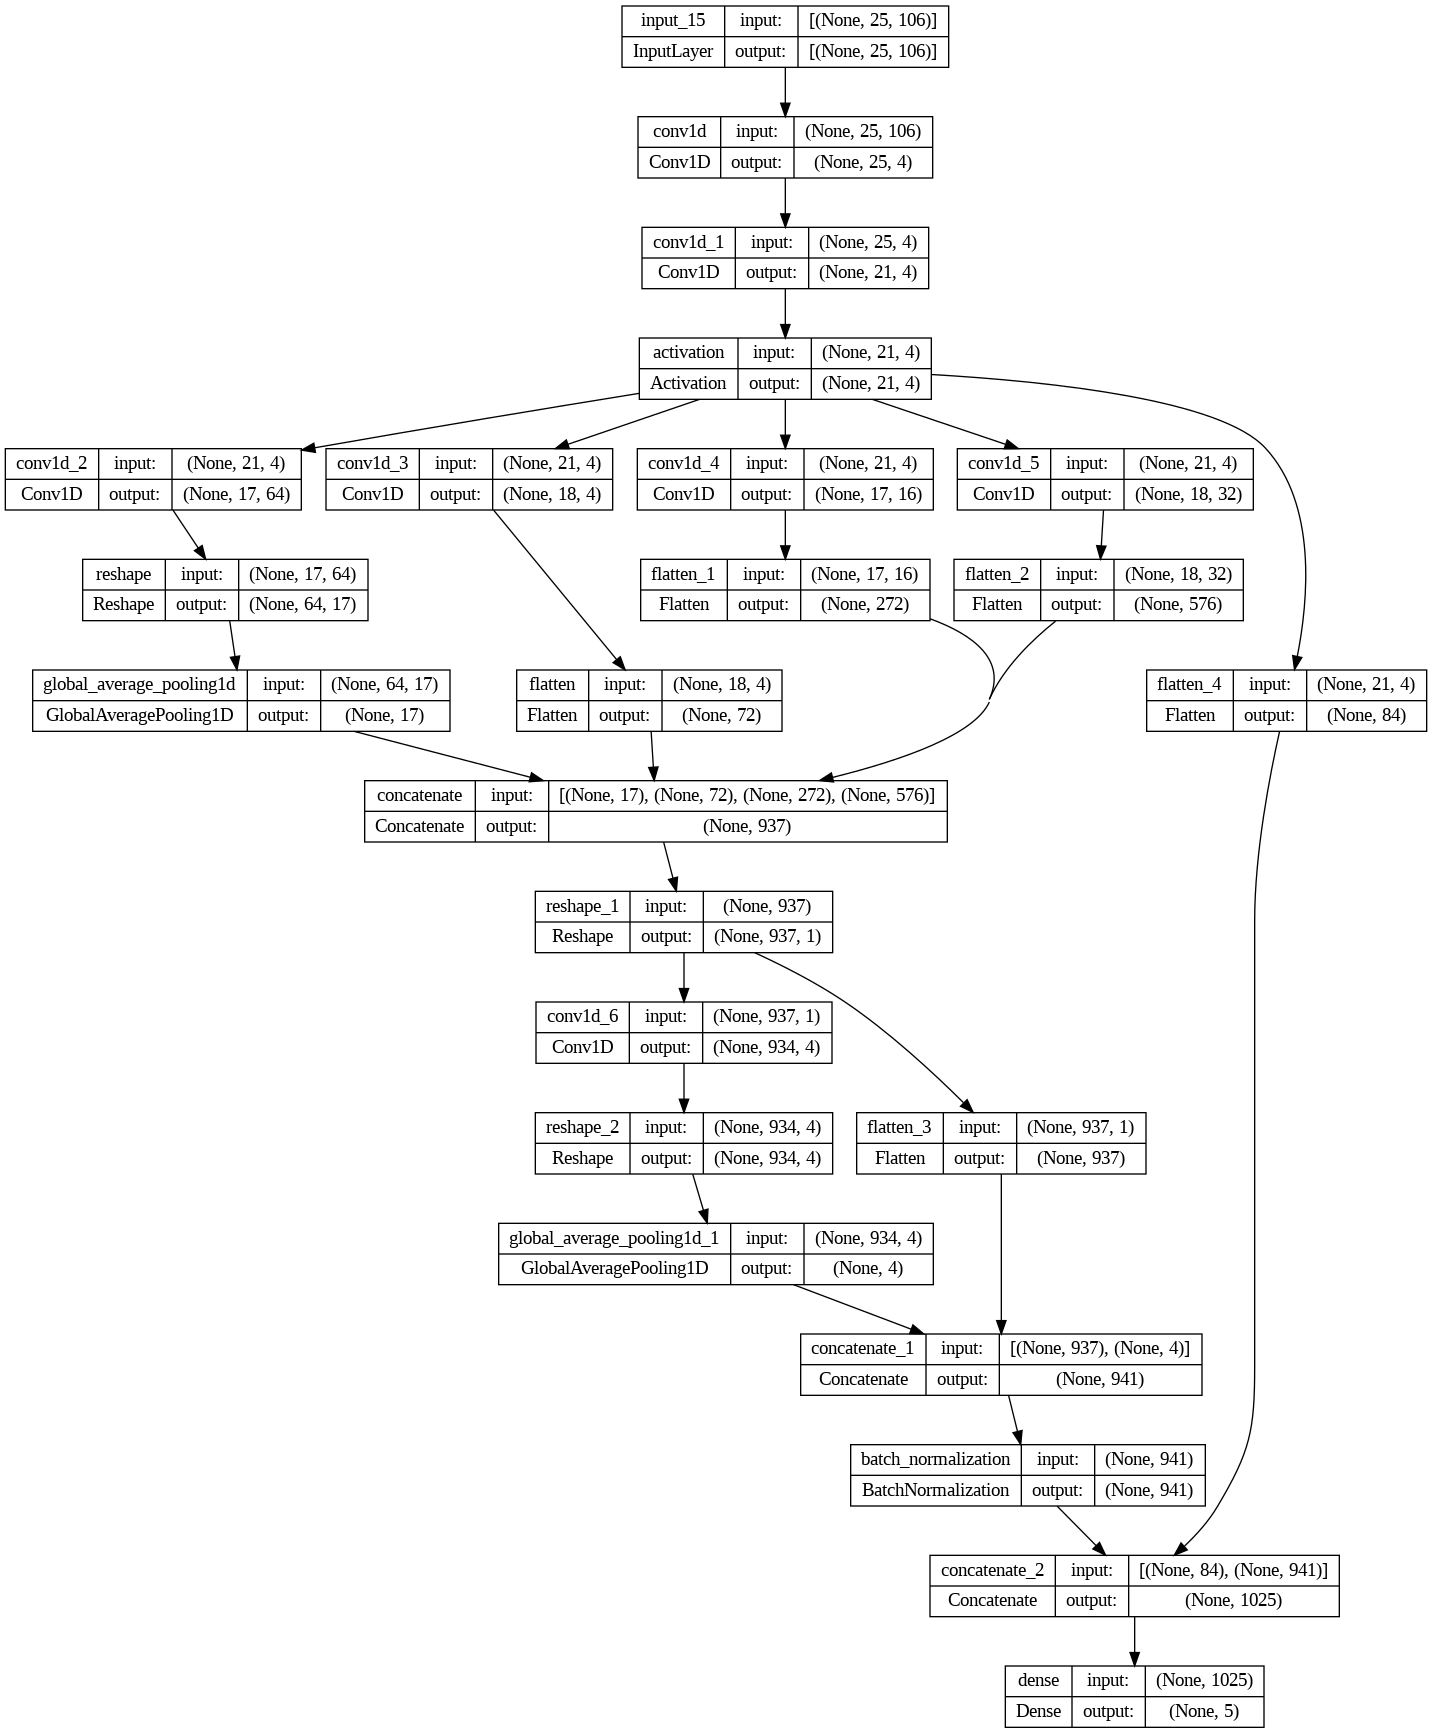

In [24]:
# дерево модели
tf.keras.utils.plot_model(good_model, show_shapes=True)

In [25]:
k = 1 # указываем индекс от 0 до n-1 для выбора модели
good_model_1 = set_models[k]
good_model_1.call = tf.function(good_model_1.call)
#k = 2 # указываем индекс от 0 до n-1 для выбора модели
#good_model_2 = set_models[k]
#good_model_2.call = tf.function(good_model_2.call)

# Отображение сводки модели
good_model_1.summary()
#good_model_2.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_16 (InputLayer)       [(None, 25, 106)]            0         []                            
                                                                                                  
 dense_1 (Dense)             (None, 25, 32)               3424      ['input_16[0][0]']            
                                                                                                  
 layer_normalization (Layer  (None, 25, 32)               64        ['dense_1[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_1 (Activation)   (None, 25, 32)               0         ['layer_normalization[0]

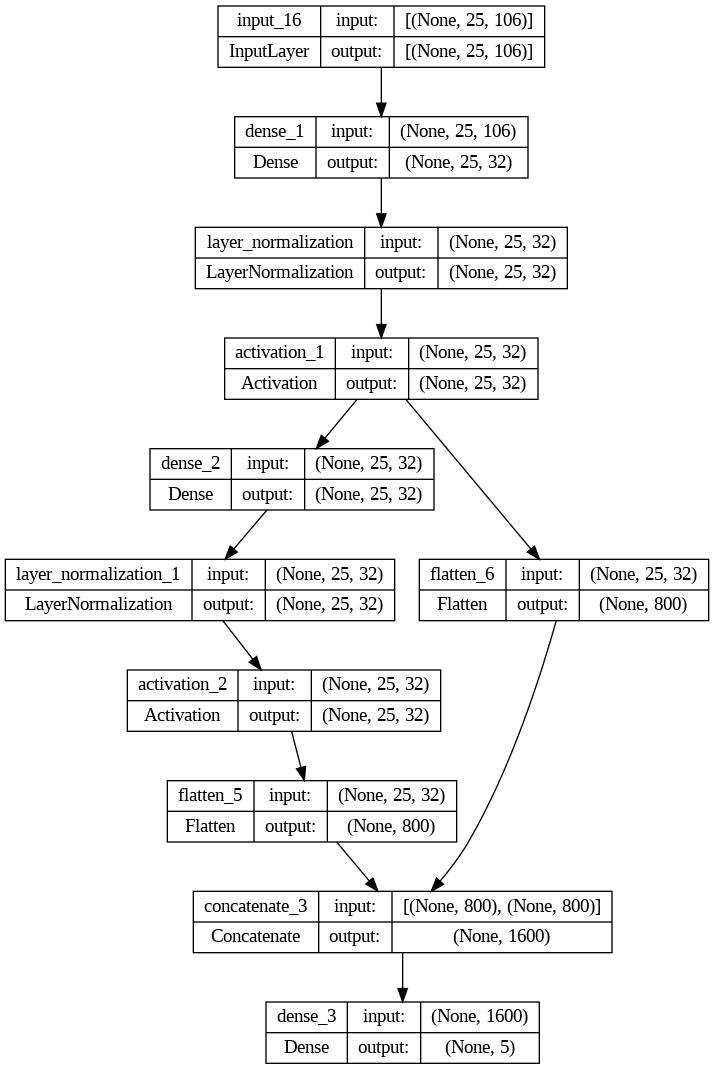

In [26]:
# дерево модели
tf.keras.utils.plot_model(good_model_1, show_shapes=True)